In [35]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler


import torch


In [36]:
#Mount drive to access files

drive.mount('/content/drive')

#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#Reading train and test data
pd.set_option('max_columns', 50)

df_train = pd.read_csv('/content/drive/My Drive/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/test.csv')

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
#############################################
# Data observing and preprocess             #
#############################################


# Features where NA values are informative
df_na_info = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish',
                       'GarageQual','GarageCond','PoolQC','Fence','MiscFeature']



#Features with real missing values
df_na_missing = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood',
                          'Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl',
                          'Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                          'TotalBsmtSF','Heating','HeatingQC','CentralAir','Electrical','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath',
                        'BsmtHalfBath','FullBath','HalfBath','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces',#'GarageYrBlt',
                       'GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal',
                       'MoSold','YrSold','SaleType','SaleCondition']
# Ordinal variables

df_ordinals = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']

#Numerical variables

df_nums = pd.Series.to_frame(df_train.corr()['SalePrice'])
df_nums = df_nums.T.columns.tolist()


#Categorical variables

cat_vals = []

for i in df_train.columns:
  if i not in df_train[df_ordinals].columns and i not in df_train[df_nums].columns:
    cat_vals.append(i)


In [37]:
# Columns with missing values (with both informative and non-informative NA values)
print("Missing values in training set: ")
print(df_train.isnull().sum()[df_train.isnull().sum()>0])
print()
print("Missing values in the test set: ")
print(df_test.isnull().sum()[df_test.isnull().sum()>0])

Missing values in training set: 
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Missing values in the test set: 
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish     

In [39]:
from random import randrange

# Handling missing values

# Dropping data from features where missing value cardinality is less than 10, and NA is non-informative

def drop_nas(df):
  for i in df.columns:
    if(df[i].isnull().sum()<10 and df[i].isnull().sum()>0):
      df.drop(df.index[pd.isna(df[i])], inplace=True)


drop_nas(df_train)
drop_nas(df_test)


# Replacing informative missing values (where NA represents actual knowledge about a sample) with 'None', since these columns are not numerical dtypes

df_train[df_na_info] = df_train[df_na_info].fillna('None')
df_test[df_na_info] = df_test[df_na_info].fillna('None')

#Imputing missing values with mean or random values

def impute(df):
  for i in df.columns:
    if(i in df_na_missing):
      if(df[i].dtype == 'O'):
        df[i] = df[i].astype('str')
        col_values = np.unique(df[i])
        df[i].fillna(col_values[randrange(0,len(col_values))], inplace=True)
      if(df[i].dtype == 'int64' or df[i].dtype == 'float64'):
        df[i].fillna(df[i].mean(), inplace=True)



impute(df_train)
impute(df_test)

In [11]:
#Searching for inconsistent and outlier elements

for i in df_train.columns:
  print(i)
  print(np.unique(df_train[i]))

for i in df_test.columns:
  print(i)
  print(np.unique(df_train[i]))


Id
[   1    2    3 ... 1458 1459 1460]
MSSubClass
[ 20  30  40  45  50  60  70  75  80  85  90 120 160 180 190]
MSZoning
['C (all)' 'FV' 'RH' 'RL' 'RM']
LotFrontage
[ 21.          24.          30.          32.          33.
  34.          35.          36.          37.          38.
  39.          40.          41.          42.          43.
  44.          45.          46.          47.          48.
  49.          50.          51.          52.          53.
  54.          55.          56.          57.          58.
  59.          60.          61.          62.          63.
  64.          65.          66.          67.          68.
  69.          70.          70.02763819  71.          72.
  73.          74.          75.          76.          77.
  78.          79.          80.          81.          82.
  83.          84.          85.          86.          87.
  88.          89.          90.          91.          92.
  93.          94.          95.          96.          97.
  98.          99.     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


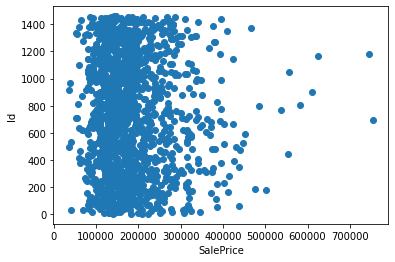

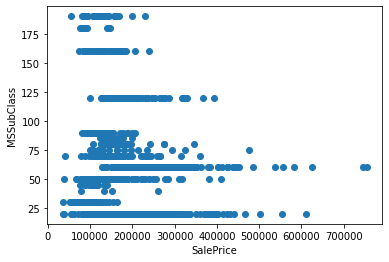

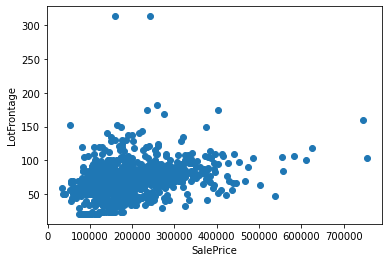

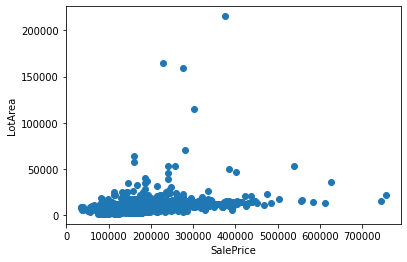

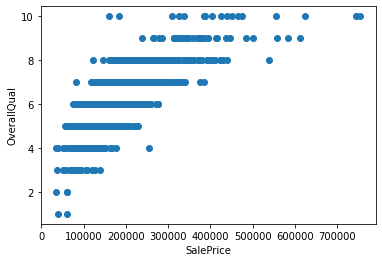

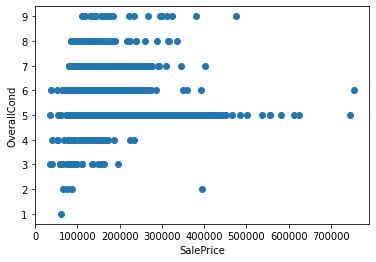

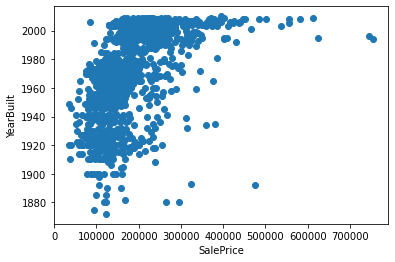

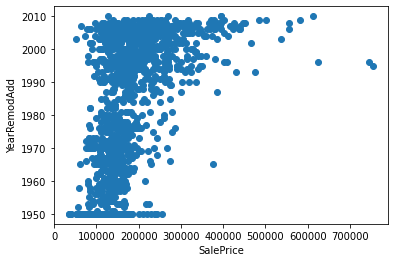

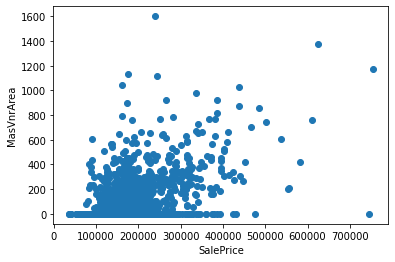

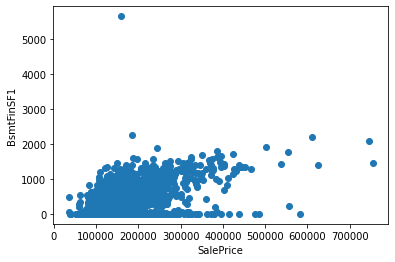

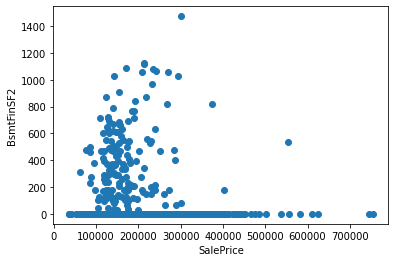

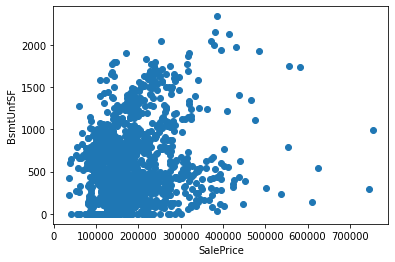

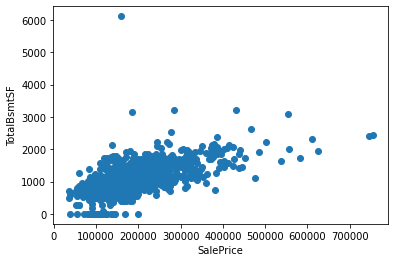

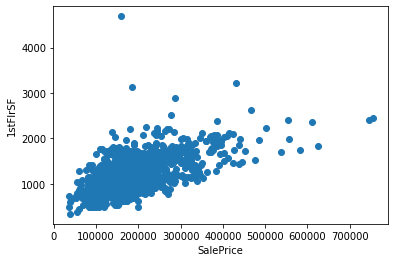

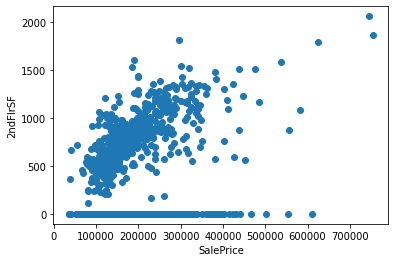

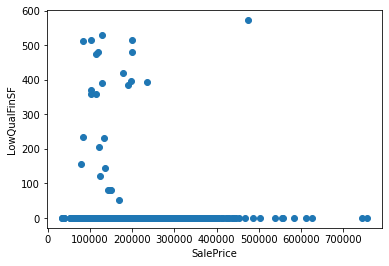

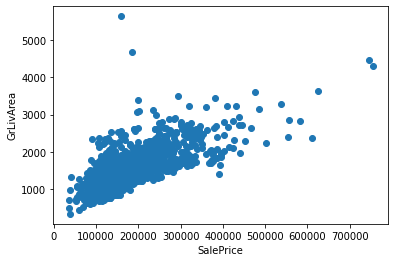

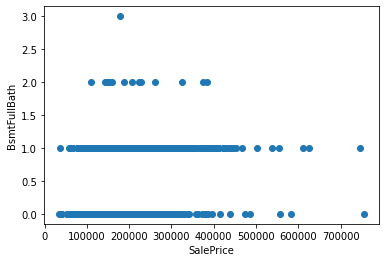

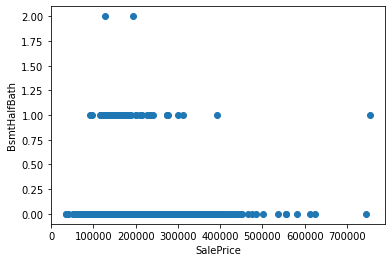

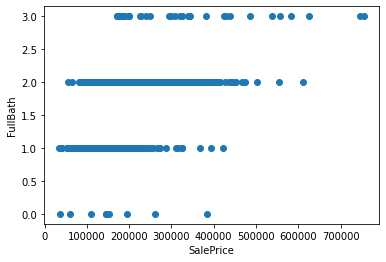

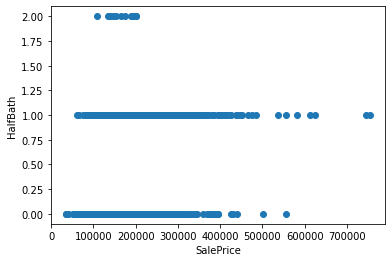

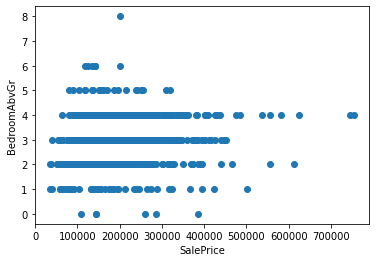

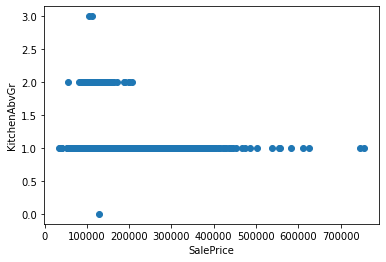

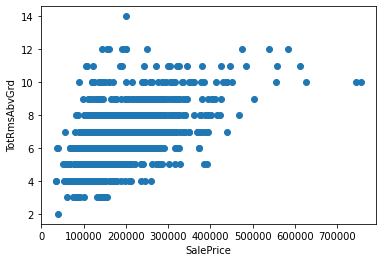

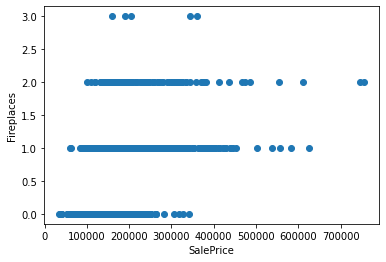

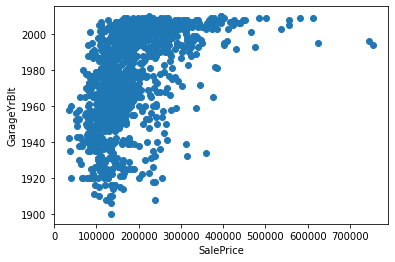

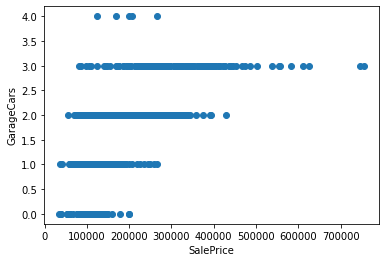

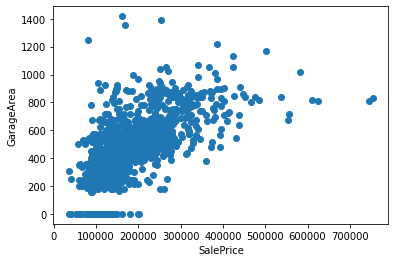

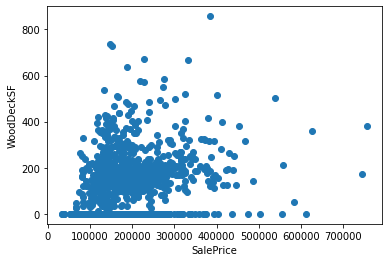

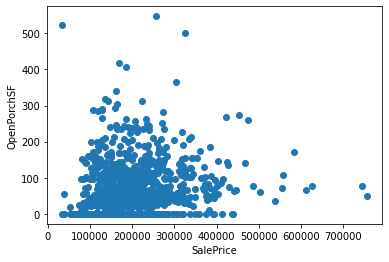

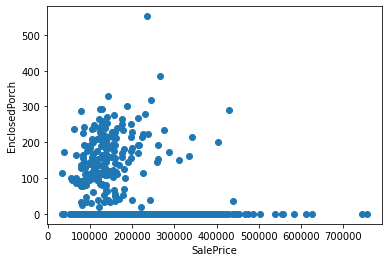

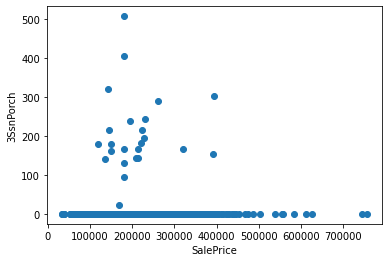

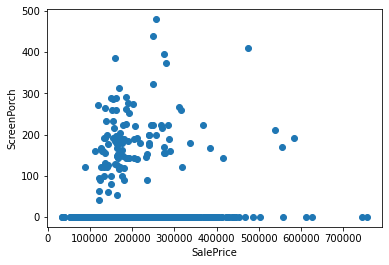

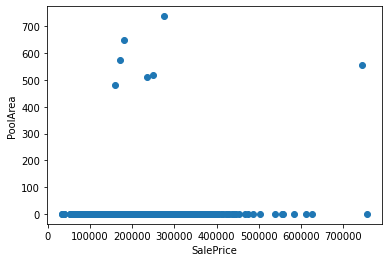

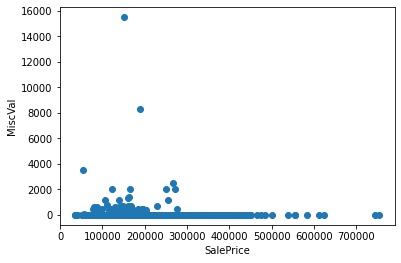

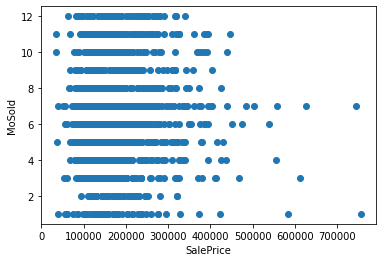

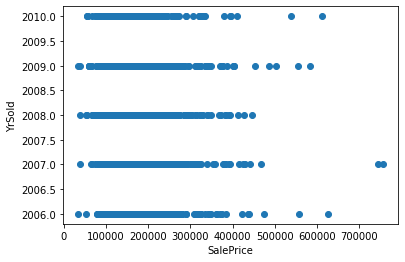

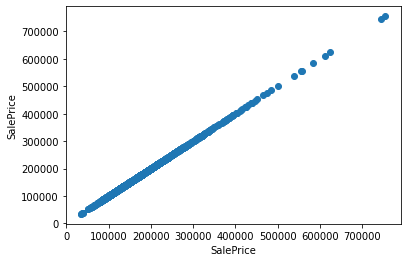

In [31]:
#Visualizing numerical data

for i in df_nums:

  plt.subplots()
  plt.xlabel('SalePrice')
  plt.ylabel(i)
  plt.scatter(df_train['SalePrice'],df_train[i])
  plt.plot()


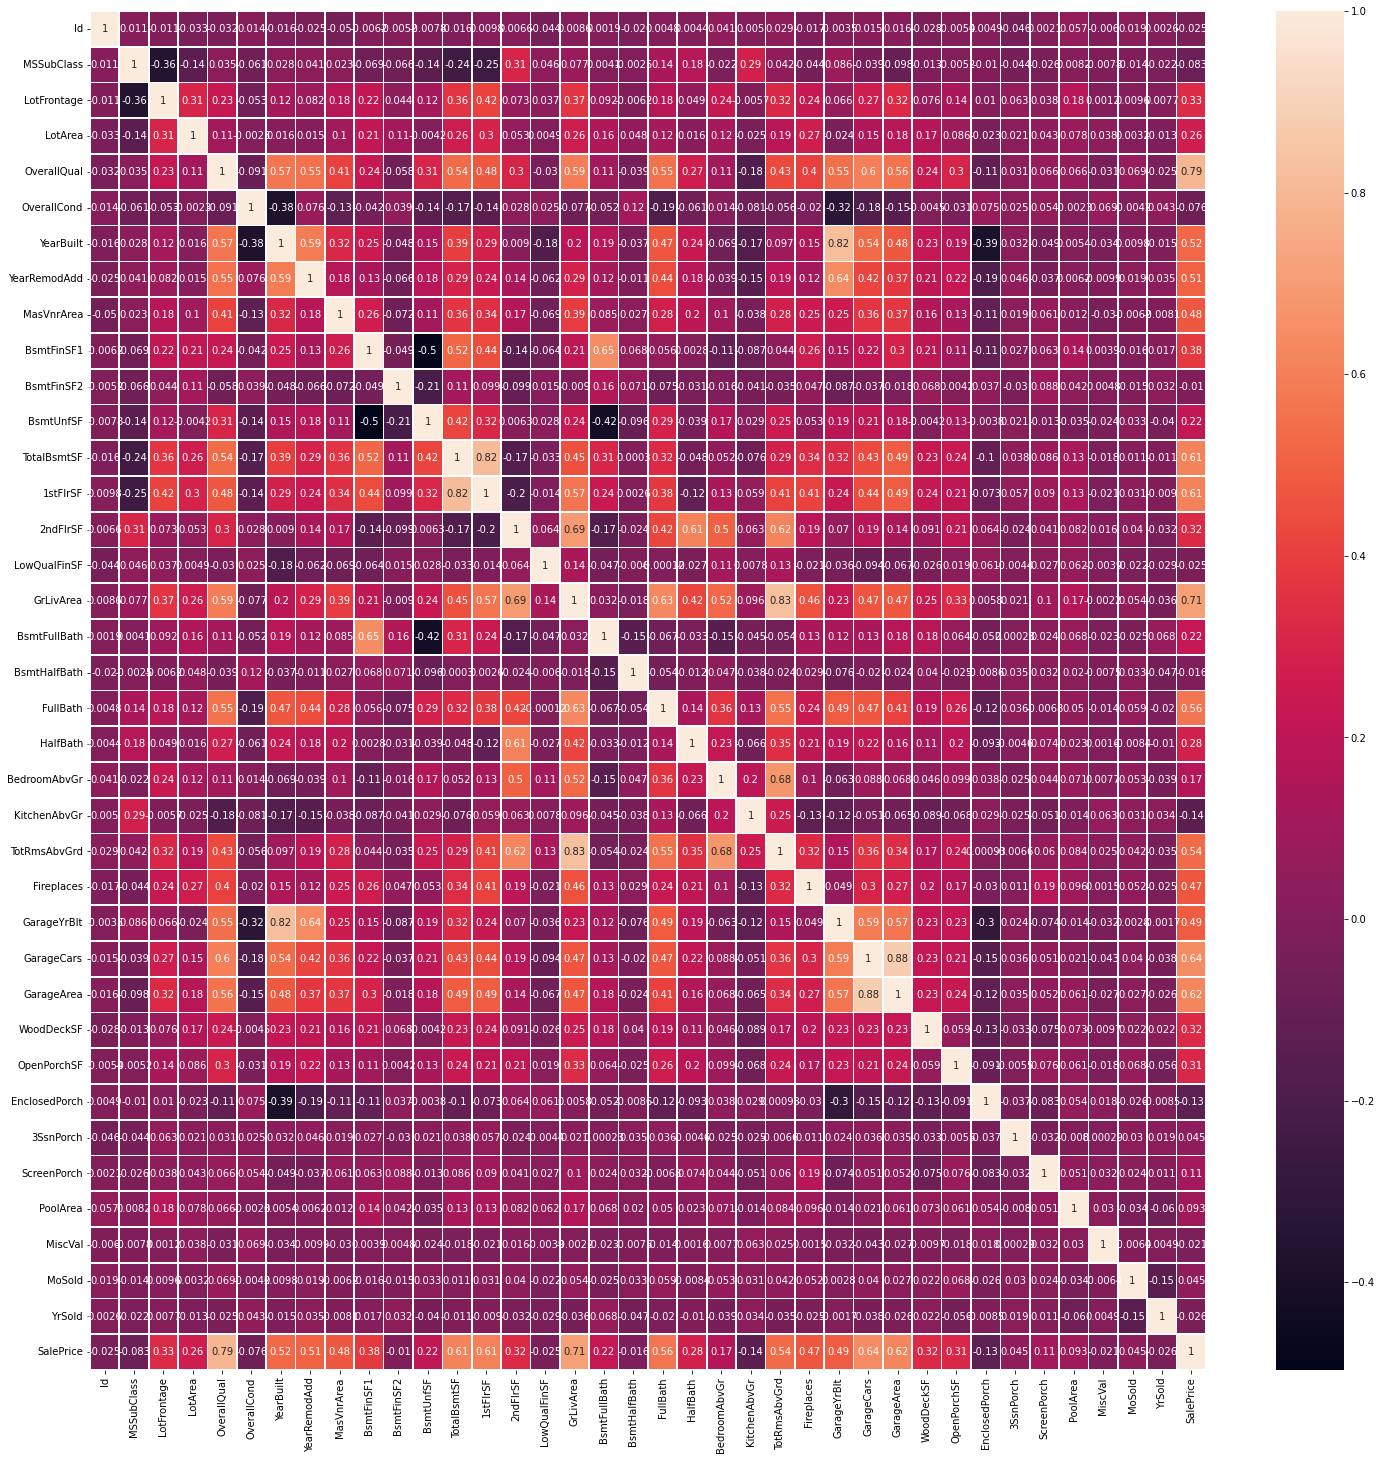

In [ ]:
#Creating correlation matrix for observing numerical data

fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(df_train.corr(), annot = True, linewidths=.7)


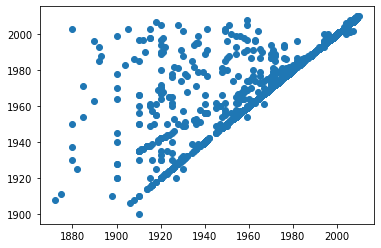

In [29]:
# YearBuilt and GarageYrBlt seems to have a linear relationship

plt.scatter(df_train[["YearBuilt"]],df_train[["GarageYrBlt"]])

In [12]:
#Based on the correlation matrix and the plot, the variable YearBuilt and GarageYrBlt is highly correlated

print("Missing values for training set:")
print(df_train.isnull().sum()[df_train.isnull().sum()>0])
print() 
print("Missing values for test set:")
print(df_test.isnull().sum()[df_test.isnull().sum()>0])

Missing values for training set:
GarageYrBlt    81
dtype: int64

Missing values for test set:
GarageYrBlt    76
dtype: int64


In [40]:
# Getting the indexes and X,Y sets for YearBuilt and GarageYrBlt

df_garage_pred_train_X = df_train[["YearBuilt"]]
df_garage_pred_train_Y = df_train[["GarageYrBlt"]] 

df_garage_pred_train_X = df_garage_pred_train_X.drop(df_garage_pred_train_X.index[df_garage_pred_train_Y["GarageYrBlt"].isnull()])
df_garage_pred_train_Y = df_garage_pred_train_Y.drop(df_garage_pred_train_Y.index[df_garage_pred_train_Y["GarageYrBlt"].isnull()])

df_garage_pred_test_X = df_train["YearBuilt"][df_train["GarageYrBlt"].isnull()]
df_garage_pred_test_X = df_garage_pred_test_X[:,np.newaxis]

print(df_train["GarageYrBlt"].isnull().sum())

81


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


In [41]:
# Because the task is linear regression, i can use the analytical solution so
# I will predict the missing values for GarageYrBlt from YearBuilt, with normal equation


def show_pred(X, theta):
    X = np.concatenate((np.ones(1),np.array(X)),axis=0)
    return np.round(np.dot(X, theta),1)


train_x = np.array([np.ones(len(df_garage_pred_train_X)),np.asarray(df_garage_pred_train_X).flatten()]).T
prices = np.linalg.inv(train_x.T.dot(train_x)).dot(train_x.T).dot(df_garage_pred_train_Y)
ars = np.array((2001)).reshape(1)


grg_index = df_train["GarageYrBlt"].index[pd.isna(df_train["GarageYrBlt"])]      #np.argwhere(np.asarray(pd.isna(df_train["GarageYrBlt"]))) --> ez rosszul adja vissza az indexeket, a df.index és pd.isna komnó a helyes
grg_na_index = df_train['YearBuilt'][np.squeeze(grg_index)]

print("Predicted Theta: ")
print(prices)


# Imputing missing values with hte predicted ones

for i in np.squeeze(grg_index):
  yr_arr = np.asarray(df_train['YearBuilt'][i]).reshape(1)
  df_train["GarageYrBlt"][i] = np.round(show_pred(yr_arr,prices))

Predicted Theta: 
[[611.25844765]
 [  0.69297748]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
print("Number of missing values: ")
print(pd.isna(df_train["GarageYrBlt"]).sum())

Number of missing values: 
0


In [30]:
# Alternatively, i could you a simple linear model to predict the missing values

'''
from sklearn.linear_model import LinearRegression

model = LinearRegression()

reg = model.fit(df_garage_pred_train_X,df_garage_pred_train_Y)

print(reg.score(df_garage_pred_train_X,df_garage_pred_train_Y))

pred_values = np.asarray(model.predict(df_garage_pred_test_X), dtype=np.int64)

#Imputing the missing values with the predicted ones

grg_na_index = np.argwhere(np.asarray(df_train["GarageYrBlt"].isnull()))

grg_na_index = np.squeeze(grg_na_index)
pred_values = np.squeeze(pred_values)


grg_na_idx = np.asarray(pd.Series.to_frame(df_train['GarageYrBlt'][df_train['GarageYrBlt'].isnull()]).T.columns)

df_train["GarageYrBlt"][grg_na_idx] = pred_values

df_test.isnull().sum()
'''

In [42]:
# Creating training set, then dropping non-relevant features

train_y = df_train['SalePrice']
train_x = df_train.drop(['SalePrice','Id'],axis=1)


In [127]:



#df_nums = pd.Series.to_frame(df_train.corr()["SalePrice"][df_train.corr()["SalePrice"]>0.4])

#df_nums.T.columns.tolist()

#df_train_first = df_train[df_nums.T.columns.tolist()]



#low_corr = df_train.corr()['SalePrice'].index[(df_train.corr()['SalePrice']<0.027) & (df_train.corr()['SalePrice']>-0.027)]
#low_corrs = low_corr.to_list()


train_y = df_train['SalePrice']
#train_x = df_train.drop(low_corrs, axis=1)
train_x = df_train.drop(['SalePrice','Id'],axis=1)




In [43]:
#Encoding ordinal and categorical train data into numerical

ord = OrdinalEncoder()
lab = LabelEncoder()

train_x[df_ordinals] = ord.fit_transform(train_x[df_ordinals])

for i in cat_vals:
  train_x[i] = lab.fit_transform(train_x[i])

In [44]:
#Encoding ordinal and categorical test data into numerical

ord = OrdinalEncoder()
lab = LabelEncoder()

df_test[df_ordinals] = ord.fit_transform(df_test[df_ordinals])

for i in cat_vals:
  df_test[i] = lab.fit_transform(df_test[i])

In [45]:
# Creating the linear model

model = LinearRegression()

reg = model.fit(train_x,train_y)
lin_acc = round((reg.score(train_x,train_y)*100))
print("Accuracy for linear model: ")
print(str(lin_acc)+"%")


Accuracy for linear model: 
85%


In [46]:
# Subsetting features with TreeClassifier and the Gini score

clf = ExtraTreesClassifier(n_estimators=70)
clf = clf.fit(train_x, train_y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
tree_x = model.transform(train_x)

print("New training set size with reduced features")
print(tree_x.shape)

tree_model = LinearRegression()

reg = tree_model.fit(tree_x,train_y)

tree_acc = round((reg.score(tree_x,train_y)*100))
print("Accuracy for liner model with tree feature selection: ")
print(str(tree_acc)+"%")

#TODO Cross-validation and grid search with arbitrary n_estimators

New training set size with reduced features
(1451, 37)
Accuracy for liner model with tree feature selection: 
83%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [47]:
# Feature subset selection with chi sqr score
chx = SelectKBest(chi2, k=25)

chi_x = chx.fit_transform(train_x,train_y)

print("New train set with reduced features: ")
print(chi_x.shape)

chi_model = LinearRegression()

reg = chi_model.fit(chi_x,train_y)

chi_acc = round((reg.score(chi_x,train_y)*100))
print("Accuracy for liner model with chi sqr feature selection: ")
print(str(chi_acc)+"%")

New train set with reduced features: 
(1451, 25)
Accuracy for liner model with chi sqr feature selection: 
73%


In [48]:
# Creating training and validation set for neural network

val_x = train_x[int(train_x.shape[0]*0.7):train_x.shape[0]]
val_y = train_y[int(train_y.shape[0]*0.7):train_y.shape[0]]
val_y = val_y[:,np.newaxis]

train_x = train_x[:int(train_x.shape[0]*0.7)]
train_y = train_y[:int(train_y.shape[0]*0.7)]
train_y = train_y[:,np.newaxis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [ ]:
# Normalizing values for DL algoithm




In [51]:
# Creating the network architecture

inp = tf.keras.layers.Input(train_x.shape[1])
x = tf.keras.layers.Dense(1)(inp)

nn_model = tf.keras.Model(inputs=[inp],outputs = x)

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='msle')

nn_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 79)]              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 80        
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Training the FC network

history = nn_model.fit(train_x,train_y, validation_data=(val_x,val_y),epochs=50, batch_size=8,shuffle = True)

Epoch 1/500
127/127 [==============================] - 2s 7ms/step - loss: 8.5256 - val_loss: 5.5327
Epoch 2/500
127/127 [==============================] - 1s 7ms/step - loss: 4.6291 - val_loss: 3.8669
Epoch 3/500
127/127 [==============================] - 1s 7ms/step - loss: 3.4354 - val_loss: 3.0056
Epoch 4/500
127/127 [==============================] - 1s 5ms/step - loss: 2.7458 - val_loss: 2.4548
Epoch 5/500
127/127 [==============================] - 1s 7ms/step - loss: 2.2808 - val_loss: 2.0656
Epoch 6/500
127/127 [==============================] - 1s 5ms/step - loss: 1.9407 - val_loss: 1.7718
Epoch 7/500
127/127 [==============================] - 1s 9ms/step - loss: 1.6788 - val_loss: 1.5406
Epoch 8/500
127/127 [==============================] - 1s 4ms/step - loss: 1.4698 - val_loss: 1.3545
Epoch 9/500
127/127 [==============================] - 0s 2ms/step - loss: 1.2988 - val_loss: 1.1997
Epoch 10/500
127/127 [==============================] - 0s 2ms/step - loss: 1.1561 - val_lo

KeyboardInterrupt: ignored

In [31]:





'''
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train_x)
scaler = MinMaxScaler()
val_x = scaler.fit_transform(val_x)
scaler = MinMaxScaler()
test_x = scaler.fit_transform(np.asarray(df_test))
'''

 
#norm_layer = tf.keras.layers.Normalization(axis=None)
#norm_layer.adapt(train_x)
#train_x = norm_layer(train_x)

#norm_layer.adapt(val_x)
#val_x = norm_layer(val_x)



In [32]:

#history.predict

Epoch 1/500
4/4 [==============================] - 1s 76ms/step - loss: 25.3704 - val_loss: 19.3086
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 18.5708 - val_loss: 16.3907
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 15.9602 - val_loss: 14.5817
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 14.3371 - val_loss: 13.3235
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 13.1690 - val_loss: 12.3930
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 12.3016 - val_loss: 11.6727
Epoch 7/500
4/4 [==============================] - 0s 12ms/step - loss: 11.6237 - val_loss: 11.0948
Epoch 8/500
4/4 [==============================] - 0s 12ms/step - loss: 11.0734 - val_loss: 10.6175
Epoch 9/500
4/4 [==============================] - 0s 14ms/step - loss: 10.6224 - val_loss: 10.2144
Epoch 10/500
4/4 [==============================] - 0s 12ms/step - loss: 10.2184 - val_loss: 9.8672


In [ ]:
test_x = df_test.drop(df_test.index[df_test['GarageYrBlt'].isnull()])

#scaler = MinMaxScaler()
#test_x = scaler.fit_transform(test_x)


In [ ]:

#norm_layer = tf.keras.layers.Normalization(axis=None)
#norm_layer.adapt(df_test)
#test_x = norm_layer(df_test)

testres = nn_model.predict(test_x)

In [ ]:
scaler = MinMaxScaler()
print(testres[:15])
print(tests[:15])



[[50488.94 ]
 [66141.35 ]
 [57460.457]
 [50378.7  ]
 [41019.734]
 [49608.   ]
 [46204.32 ]
 [45604.81 ]
 [50945.496]
 [43882.86 ]
 [43395.03 ]
 [30455.258]
 [30704.357]
 [34407.34 ]
 [31438.014]]
[[ 76117.55203424]
 [120733.96901493]
 [122475.44883247]
 [138949.65055941]
 [139845.30623428]
 [115387.3647957 ]
 [127006.09788708]
 [108938.45237641]
 [146538.05771981]
 [ 60364.40625384]
 [156251.33161698]
 [ 58038.34305262]
 [ 40501.42312419]
 [ 81276.99354089]
 [ 42007.58556282]]


In [ ]:


Cross-vAlidation mindenképpen


SyntaxError: ignored

In [ ]:

val_x[:5]




<tf.Tensor: shape=(5, 80), dtype=float32, numpy=
array([[ 5.05916297e-01, -2.16343716e-01, -2.28597626e-01,
        -1.84627697e-01,  5.10762072e+00, -2.30039269e-01,
        -2.30039269e-01, -2.28597626e-01, -2.28597626e-01,
        -2.30760083e-01, -2.27876812e-01, -2.30760083e-01,
        -2.27155983e-01, -2.29318440e-01, -2.29318440e-01,
        -2.30760083e-01, -2.29318440e-01, -2.26435170e-01,
        -2.27876812e-01,  1.21520162e+00,  1.21520162e+00,
        -2.30039269e-01, -2.30039269e-01, -2.22110257e-01,
        -2.21389443e-01, -2.28597626e-01, -1.70211330e-01,
        -2.29318440e-01, -2.27876812e-01, -2.29318440e-01,
        -2.29318440e-01, -2.27876812e-01, -2.30760083e-01,
        -2.29318440e-01,  2.62279689e-01, -2.26435170e-01,
        -2.30760083e-01,  1.40461385e-01,  6.33501172e-01,
        -2.30039269e-01, -2.30760083e-01, -2.30039269e-01,
        -2.27876812e-01,  6.48638368e-01, -2.30760083e-01,
        -2.30760083e-01,  6.48638368e-01, -2.30039269e-01,
       

In [199]:
from sklearn.decomposition import PCA
#from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#pca = PCA(n_components=5)

#pca.fit(df_train)

chx = SelectKBest(chi2, k=79)



chi_test = chx.fit_transform(train_x,train_y)

print(chi_test.shape)
#df_train.isnull().sum()

(1451, 79)


In [ ]:
dtypes = df_train.columns.groupby(df_train.dtypes)

dtypes.groups

AttributeError: ignored

In [ ]:



df_nums = pd.Series.to_frame(df_train.corr()["SalePrice"][df_train.corr()["SalePrice"]>0.4])

df_nums.T.columns.tolist()

df_train_first = df_train[df_nums.T.columns.tolist()]
#df_test_first = df_test[df_nums.T.columns.tolist()]

df_train_first

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,856,856,1710,2,8,0,2003.0,2,548,208500
1,6,1976,1976,0.0,1262,1262,1262,2,6,1,1976.0,2,460,181500
2,7,2001,2002,162.0,920,920,1786,2,6,1,2001.0,2,608,223500
3,7,1915,1970,0.0,756,961,1717,1,7,1,1998.0,3,642,140000
4,8,2000,2000,350.0,1145,1145,2198,2,9,1,2000.0,3,836,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,0.0,953,953,1647,2,7,1,1999.0,2,460,175000
1456,6,1978,1988,119.0,1542,2073,2073,2,7,2,1978.0,2,500,210000
1457,7,1941,2006,0.0,1152,1188,2340,2,9,2,1941.0,1,252,266500
1458,5,1950,1996,0.0,1078,1078,1078,1,5,0,1950.0,1,240,142125


In [ ]:
from sklearn.decomposition import PCA
#from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#pca = PCA(n_components=5)

#pca.fit(df_train)

chx = SelectKBest(chi2, k=20)



chi_test = chx.fit_transform(df_train.drop('SalePrice',axis=1).astype(int),df_train['SalePrice'])





ValueError: ignored

In [ ]:
idx_list = df_nums.T.columns.tolist()
idx_list.remove('SalePrice')

df_test_first = df_test[idx_list]

df_train_first.isnull().sum()

OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt     81
GarageCars       0
GarageArea       0
SalePrice        0
dtype: int64

ValueError: ignored

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_garage_pred_train_X = df_train_first[["YearBuilt"]]
df_garage_pred_train_Y = df_train_first[["GarageYrBlt"]] 

df_garage_pred_train_X = df_garage_pred_train_X.drop(df_garage_pred_train_X.index[df_garage_pred_train_Y["GarageYrBlt"].isnull()])
df_garage_pred_train_Y = df_garage_pred_train_Y.drop(df_garage_pred_train_Y.index[df_garage_pred_train_Y["GarageYrBlt"].isnull()])

scaler = MinMaxScaler()

#scaler.fit(df_garage_pred_train_X)

#df_garage_pred_train_X = scaler.transform(df_garage_pred_train_X)

df_garage_pred_test_X = df_train_first["YearBuilt"][df_train_first["GarageYrBlt"].isnull()]
df_garage_pred_test_X = df_garage_pred_test_X[:,np.newaxis]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

reg = model.fit(df_garage_pred_train_X,df_garage_pred_train_Y)

print(reg.score(df_garage_pred_train_X,df_garage_pred_train_Y))

pred_values = np.asarray(model.predict(df_garage_pred_test_X), dtype=np.int64)


0.6798029043389211


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:

grg_na_index = np.argwhere(np.asarray(df_train_first["GarageYrBlt"].isnull()))

grg_na_index = np.squeeze(grg_na_index)
pred_values = np.squeeze(pred_values)




grg_na_idx = np.asarray(pd.Series.to_frame(df_train_first['GarageYrBlt'][df_train_first['GarageYrBlt'].isnull()]).T.columns)



df_train_first["GarageYrBlt"][grg_na_idx] = pred_values


#df_train_first["GarageYrBlt"][100:150]

df_train_first.isnull().sum()

#df_train_first = df_train_first["GarageYrBlt"].fillna(value=pred_values)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)


OverallQual     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
SalePrice       0
dtype: int64

In [ ]:

df_train_y = df_train_first['SalePrice']

df_train_first.drop('SalePrice', axis=1, inplace=True)

df_train_x = df_train_first



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:



model_2 = LinearRegression()


res = model_2.fit(df_train_x,df_train_y)

res.score(df_train_x,df_train_y)

0.7825642173575105

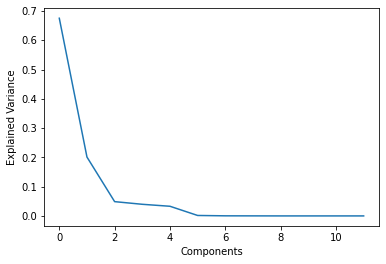

In [ ]:

from sklearn.decomposition import PCA
#from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pca = PCA(n_components=12)

pca_res = pca.fit(df_train_first)


chx = SelectKBest(chi2, k='all')

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

chi_test = chx.fit_transform(df_train_x,df_train_y)

In [ ]:
chi_test.shape

(1451, 13)

In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
model2 = LinearRegression()

sfs1 = SFS(model2, 
           k_features=80, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring=None,
           cv=0)

sfs1 = sfs1.fit(train_x,train_y)




sfs1.subsets_





[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.1s finished

[2022-03-12 16:31:53] Features: 1/80 -- score: 0.624234181028378[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.1s finished

[2022-03-12 16:31:53] Features: 2/80 -- score: 0.713622033441692[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.1s finished

[2022-03-12 16:31:53] Features: 3/80 -- score: 0.7455036160512213[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

{1: {'avg_score': 0.624234181028378,
  'cv_scores': array([0.62423418]),
  'feature_idx': (17,),
  'feature_names': ('OverallQual',)},
 2: {'avg_score': 0.713622033441692,
  'cv_scores': array([0.71362203]),
  'feature_idx': (17, 46),
  'feature_names': ('OverallQual', 'GrLivArea')},
 3: {'avg_score': 0.7455036160512213,
  'cv_scores': array([0.74550362]),
  'feature_idx': (17, 34, 46),
  'feature_names': ('OverallQual', 'BsmtFinSF1', 'GrLivArea')},
 4: {'avg_score': 0.7681009438799001,
  'cv_scores': array([0.76810094]),
  'feature_idx': (17, 27, 34, 46),
  'feature_names': ('OverallQual', 'ExterQual', 'BsmtFinSF1', 'GrLivArea')},
 5: {'avg_score': 0.7844594857669849,
  'cv_scores': array([0.78445949]),
  'feature_idx': (17, 27, 34, 46, 61),
  'feature_names': ('OverallQual',
   'ExterQual',
   'BsmtFinSF1',
   'GrLivArea',
   'GarageCars')},
 6: {'avg_score': 0.7957629840297612,
  'cv_scores': array([0.79576298]),
  'feature_idx': (1, 17, 27, 34, 46, 61),
  'feature_names': ('MSSubCl

In [ ]:
'''
Dataset Cél:
 - Legjobb featureket kiválasztani
 - Azeket a featureket pre-processingolni
 - különböző modellek kipróbálása, grid searchel is
 - Több model összehasonlítása, kiértékelése
 - Ugyanezt megcsinálni neuronhálókkal


Ezután Klasszifikáció/Képek klasszifikálása:
 - Klasszifikációs dataset sima ML modellekhez
 - Képek klasszifikálása neuronhálókhoz
 - Pythorchban megírni valamelyiket

 - PL/SQL kódokat feltölteni

 - R kódokat feltölteni

'''